In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from grid2op.PlotGrid import PlotMatplot
import grid2op
from dataclasses import dataclass
import scipy

import torch
from torch_geometric.data import Data


In [2]:
import os
from grid2op import make

# Initialize the env.
env = make("rte_case5_example", test=True)

/home/matthijs/Software/anaconda3/lib/python3.8/site-packages/grid2op/MakeEnv/Make.py:317: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


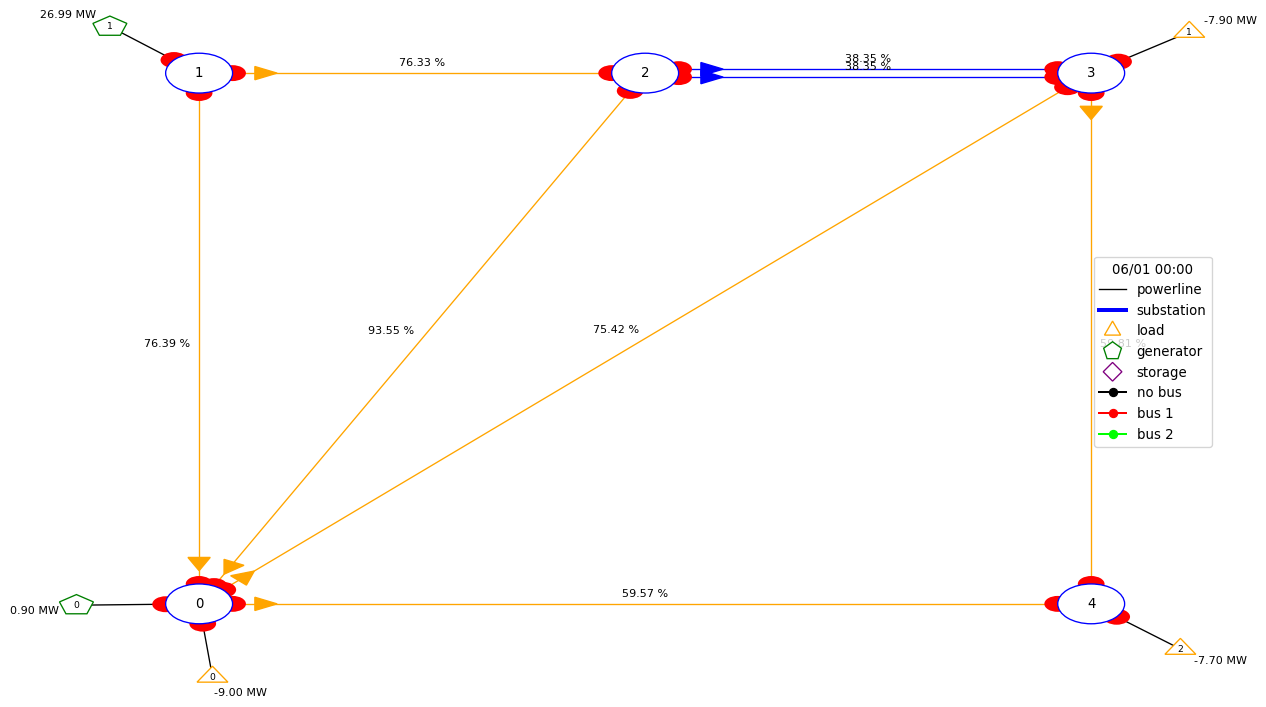

In [3]:
plot_helper = PlotMatplot(env.observation_space)

obs = env.reset()
fig = plot_helper.plot_obs(obs)

In [4]:
action_space = env.action_space
observation_space = env.observation_space

# Create do_nothing action.
agent_action = action_space({}) # this is the do nothing action
obs, *_ = env.step(agent_action)
print(type(obs))
print(obs.to_dict()) # TODO: does not contain all attributes, e.g. time

<class 'grid2op.Space.GridObjects.CompleteObservation_rte_case5_example'>
{'timestep_overflow': array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), 'line_status': array([ True,  True,  True,  True,  True,  True,  True,  True]), 'topo_vect': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32), 'loads': {'p': array([8.9, 7.9, 7.5], dtype=float32), 'q': array([6.2, 5.5, 5.3], dtype=float32), 'v': array([102.     , 101.89334, 101.84712], dtype=float32)}, 'prods': {'p': array([ 0.9     , 26.591259], dtype=float32), 'q': array([ 158.07407, -159.94029], dtype=float32), 'v': array([102., 102.], dtype=float32)}, 'gens': {'p': array([ 0.9     , 26.591259], dtype=float32), 'q': array([ 158.07407, -159.94029], dtype=float32), 'v': array([102., 102.], dtype=float32)}, 'lines_or': {'p': array([-9.585901  , -2.3974745 ,  0.13034806,  3.853028  , 15.381992  ,
        5.914517  ,  5.914517  ,  3.783845  ], dtype=float32), 'q': array([ 79.15685 ,  35.693317,  20.958063,  

In [5]:
def extract_gen_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.gen_pos_topo_vect
    X = np.array(list(obs.to_dict()['gens'].values())).T
    return i,X

def extract_load_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.load_pos_topo_vect
    X = np.array(list(obs.to_dict()['loads'].values())).T
    return i,X

def extract_or_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.line_or_pos_topo_vect
    X = np.array(list(obs.to_dict()['lines_or'].values())).T
    X = np.concatenate((X,np.reshape(np.array(obs.to_dict()['rho']),(-1,1))),axis=1)
    return i,X

def extract_ex_features(obs: grid2op.Observation.CompleteObservation):
    i = obs.line_ex_pos_topo_vect
    X = np.array(list(obs.to_dict()['lines_ex'].values())).T
    X = np.concatenate((X,np.reshape(np.array(obs.to_dict()['rho']),(-1,1))),axis=1)
    return i,X

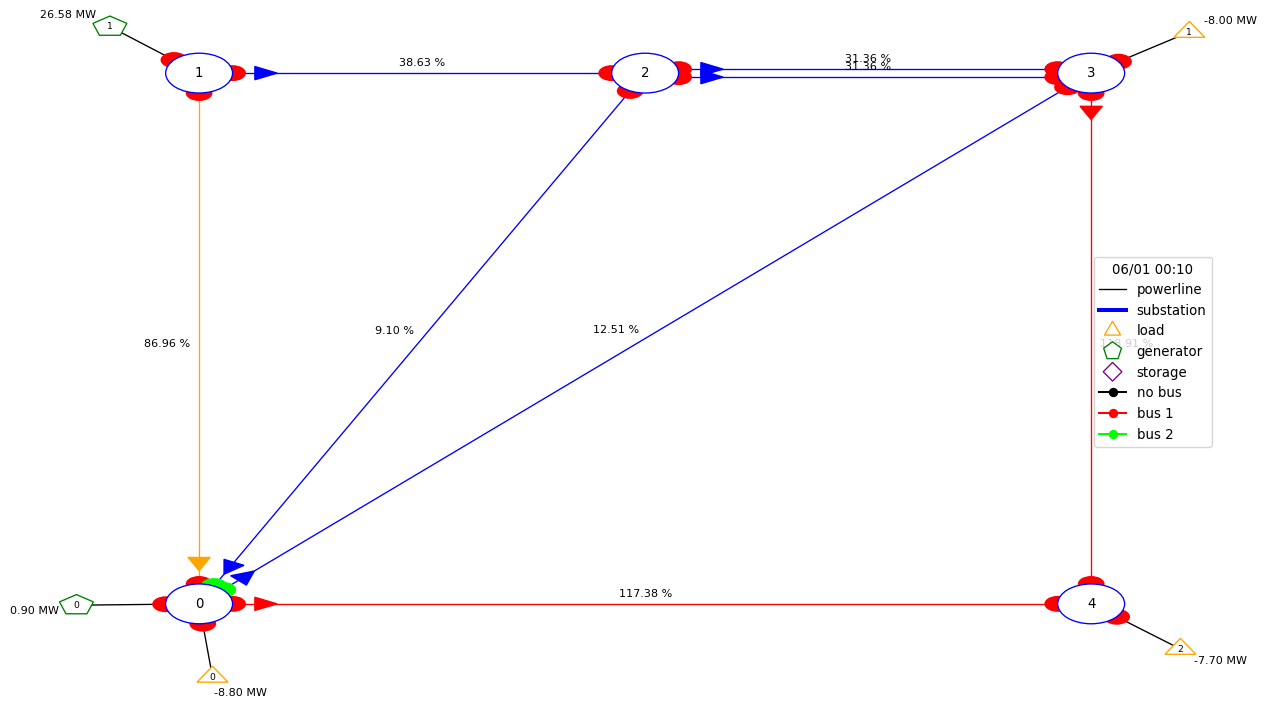

In [6]:
agent_action = action_space()
agent_action.change_bus = [1,2]
obs, *_ = env.step(agent_action)
fig = plot_helper.plot_obs(obs)

In [7]:
@dataclass
class Gen:
    '''
    Dataclass for the static features of a generator
    '''
    id: int
    sub_id: int #Id of the substation
    sub_pos: int #position (RELATIVE) at its substation
    pos: int #position (ABSOLUTE)
        
gens = [Gen(*x) for x in zip(list(range(env.observation_space.n_gen)),
    env.observation_space.gen_to_subid,
    env.observation_space.gen_to_sub_pos,
    env.observation_space.gen_pos_topo_vect)]

@dataclass
class Load:
    '''
    Dataclass for the static features of a load
    '''
    id: int
    sub_id: int #Id of the substation
    sub_pos: int #position (RELATIVE) at its substation
    pos: int #position (ABSOLUTE)
        
loads = [Load(*x) for x in zip(list(range(env.observation_space.n_load)),
    env.observation_space.load_to_subid,
    env.observation_space.load_to_sub_pos,
    env.observation_space.load_pos_topo_vect)]

@dataclass
class PowerLine:
    '''
    Dataclass for the static features of a powerline
    '''
    id: int
    or_sub_id: int #Id of the origin substation
    ex_sub_id: int #Id of the extremity substation
    or_sub_pos: int #Origin position (RELATIVE) at its substation
    ex_sub_pos: int #Extremity position (RELATIVE) at its substation
    or_pos: int #Origin position (ABSOLUTE)
    ex_pos: int #Extremity position (ABSOLUTE)
        
lines = [PowerLine(*x) for x in zip(list(range(env.observation_space.n_line)),
    env.observation_space.line_or_to_subid,
    env.observation_space.line_ex_to_subid,
    env.observation_space.line_or_to_sub_pos,
    env.observation_space.line_ex_to_sub_pos,
    env.observation_space.line_or_pos_topo_vect,
    env.observation_space.line_ex_pos_topo_vect)]

Toying around with PyG

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

conmatrix = obs.connectivity_matrix(as_csr_matrix=True)
conmatrix = conmatrix - scipy.sparse.identity(conmatrix.shape[0])
coo_conmatrix = conmatrix.tocoo()
or_ex_indices = np.concatenate((obs.line_or_pos_topo_vect,obs.line_ex_pos_topo_vect))
edges = zip(coo_conmatrix.row,coo_conmatrix.col)

N_features = 3+5
n=observation_space.n_gen+observation_space.n_load+2*observation_space.n_line
N_classes=4

def extract_features(obs: grid2op.Observation.CompleteObservation):
    X=np.zeros((n,N_features))
    T=np.zeros(n)
    for t,f in enumerate([extract_gen_features,extract_load_features,extract_or_features,extract_ex_features]):
        if t < 2:
            for i,x in zip(*f(obs)):
                X[i,:3]=x
                T[i]=t
        else:
            for i,x in zip(*f(obs)):
                X[i,3:]=x   
                T[i]=t
    return X,T

X,T = extract_features(obs)
X=torch.tensor(X,dtype=torch.float,device=device)
edge_index=torch.tensor(list(edges),dtype=torch.long,device=device).T
T = torch.tensor(T,dtype=torch.long,device=device)

In [54]:
from torch_geometric.nn import  SAGEConv, Linear
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(N_features,16)
        self.conv2 = SAGEConv(16,16)
        self.conv3 = SAGEConv(16,N_classes)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)
        x = self.conv3(x, edge_index)
        
        return F.softmax(x, dim=1)

In [55]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=5e-4)


model.train()
for epoch in range(4000):
    optimizer.zero_grad()
    out = model(X,edge_index)
    loss = F.nll_loss(out, T)
    loss.backward()
    optimizer.step()
    #print(loss)
    #print(out)

In [50]:
T

tensor([2, 2, 2, 2, 0, 1, 3, 2, 0, 3, 3, 2, 2, 3, 3, 3, 2, 1, 3, 3, 1],
       device='cuda:0')

In [51]:
model(X,edge_index).round()

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)

In [53]:
F.nll_loss(model(X,edge_index).round(), T)

tensor(-0.9524, device='cuda:0', grad_fn=<NllLossBackward>)